Justin Wang 
December 2020


This script will resize input images to 128x128, flatten and standardize them, and store them as numpy arrays in an hd5 file for each project. 


First, we resize images from projects and places the new resized images into a directory with a matching structure/substructure as the original project folders. We are assuming a set of directories/subdirectories that follow such a structure: raw_inputfiles/project_name/train/cat/img.jpg

In [ ]:
#!/usr/bin/python
from PIL import Image
import os, sys


#project = "RashData"
#project = "chest_xray"
project = "chest_covid"
#project = "cat_dog"


path = "raw_input_files/"+project+"/"
outputpath = "resized_input_files/"+project+"/"

dirs = os.listdir( path )


def resize():
    
    #for each data_split (test, train, val)
    for item in dirs:
        
        #our new path includes the data_split
        data_split = path+item
        
        #if the path is a directory ...
        if os.path.isdir(data_split):
            
            data_split_dir = os.listdir( data_split)
            
            #then look for categories within each data_split (cat, dog)
            for category in data_split_dir:
                
                #our new path includes the category
                category_data_split = data_split+"/"+category
                
                #if the path is a directory ...
                if os.path.isdir(category_data_split):
                    
                    category_data_split_dir = os.listdir(category_data_split)
                    
                    #create output folder for this category if it doesnt exist yet
                    if not os.path.isdir(outputpath+item+"/"+category):    
                        os.mkdir(outputpath+item+"/"+category)
                    
                    #resize each image in this category & split and save it to the output path
                    for image in category_data_split_dir:
                        raw_input = category_data_split+"/"+image
                        
                        if os.path.isfile(raw_input):
                            raw_image = Image.open(raw_input)
                            raw_image = raw_image.convert("RGB")
                            f, e = os.path.splitext(image)
                            resized_image = raw_image.resize((128,128), Image.ANTIALIAS)
                            resized_image.save(outputpath+item+"/"+category+"/"+f+'_resized.jpg', 'JPEG', quality=90)
                            
  
resize()
print("done")  



Next, we need to flatten each of the resized photos and standardize their pixel values.  Each processed image can then be saved into an hdf5 file corresponding to the appropriate project. The hdf5 file is broken into a data_split/category format (e.g. the array containig images for cats in the training set would be found in the 'test/cats' dataset).

In [159]:
import h5py
from matplotlib import image
from matplotlib import pyplot
from PIL import Image
from numpy import asarray


#project = "RashData"
#project = "chest_xray"
#project = "chest_covid"
project = "cat_dog"


path = "resized_input_files/"+project+"/"

dirs = os.listdir( path )


def h5py_creation():
    
    f = h5py.File(project+".hdf5", "w")
    f = h5py.File(project+".hdf5", 'a')
    for item in dirs:   #item is split type (train,test, val etc)
       
        data_split = path+item
        
        
        if os.path.isdir(data_split):
            
            data_split_dir = os.listdir( data_split)
        
            for category in data_split_dir:    #category is cat or dog, pneumonia or normal, etc
                
                category_data_split = data_split+"/"+category
                
                if os.path.isdir(category_data_split):
                    category_data_split_dir = os.listdir(category_data_split)
                    
                    dset = f.create_dataset(item+"/"+category, (1,49152), chunks=(2,49152), maxshape=(None, 49152), dtype='f')
                    #maybe 1 instead of 2.... 
                    #128*128*3 = 49152
                    
                    first = True
                    
                    for image in category_data_split_dir:
                        
                        input_image_path = category_data_split+"/"+image
                        
                        
                        if os.path.isfile(input_image_path):
                            
                            input_image = Image.open(input_image_path)
                            data = asarray(input_image)
                            #print(data.shape)
                            pixels = data.flatten().reshape(1, 49152)/255
                            #img2 = Image.fromarray(pixels.reshape(128,128,3), 'RGB')
                            #img2.show()
                            #https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/

                        
                        
                        if first:
                            dset[-1:] = pixels
                            first = False
                        else:
                            dset.resize(dset.shape[0]+1, axis=0)
                            dset[-1:] = pixels

                        
                        
                            
    f.close()                        
    #print(f.keys())
        
h5py_creation()
print("done")

done


Lastly, let's check that the images are still intact and retrievable from the datasets.

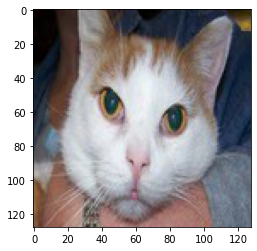

In [5]:
import numpy as np
import PIL
import h5py
from PIL import Image
from matplotlib import pyplot
#taking a peek at a certain dataset and index (x)
f = h5py.File('cat_dog.hdf5', "r")
mydset = f['val/cats']
index = 10


#de-standardize and unflatten array into image
orig_image = np.uint8((np.round(mydset[index].reshape(128,128,3) * 255.0)).astype(int))


#show with PIL
PIL_image = Image.fromarray(orig_image).convert('RGB')
PIL_image.show()


#show with pyplot
pyplot.imshow(orig_image)


f.close()

###### 